In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class TabularDataset(Dataset):
    def __init__(self, data, cat_cols=None, output_col=None):
 

        self.n = data.shape[0]

        if output_col:
            self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
        else:
            self.y =  np.zeros((self.n, 1))

        self.cat_cols = cat_cols if cat_cols else []
        self.cont_cols = [col for col in data.columns
                          if col not in self.cat_cols + [output_col]]

        if self.cont_cols:
            self.cont_X = data[self.cont_cols].astype(np.float32).values
        else:
            self.cont_X = np.zeros((self.n, 1))

        if self.cat_cols:
            self.cat_X = data[cat_cols].astype(np.int64).values
        else:
            self.cat_X =  np.zeros((self.n, 1))

    def __len__(self):
    
        return self.n

    def __getitem__(self, idx):
   
        return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]


class FeedForwardNN(nn.Module):

    def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_size, emb_dropout, lin_layer_dropouts):

    
        super().__init__()

        # Embedding layers
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                         for x, y in emb_dims])

        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.no_of_cont = no_of_cont

        # Linear Layers
        first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                    lin_layer_sizes[0])

        self.lin_layers =\
         nn.ModuleList([first_lin_layer] +\
              [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
               for i in range(len(lin_layer_sizes) - 1)])

        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                      output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                        for size in lin_layer_sizes])

        # Dropout Layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                      for size in lin_layer_dropouts])

    def forward(self, cont_data, cat_data):

        if self.no_of_embs != 0:
            x = [emb_layer(cat_data[:, i])
               for i,emb_layer in enumerate(self.emb_layers)]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x)

        if self.no_of_cont != 0:
            normalized_cont_data = self.first_bn_layer(cont_data)

            if self.no_of_embs != 0:
                x = torch.cat([x, normalized_cont_data], 1) 
            else:
                x = normalized_cont_data

        for lin_layer, dropout_layer, bn_layer in\
            zip(self.lin_layers, self.droput_layers, self.bn_layers):

            x = F.relu(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        x = self.output_layer(x)

        return x

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data['date_in'] = pd.to_datetime(data['date_in'])
data['year'] = data['date_in'].map(lambda x: x.strftime('%Y'))
data['month'] = data['date_in'].map(lambda x: x.strftime('%m'))
data['day'] = data['date_in'].map(lambda x: x.strftime('%d'))

In [4]:
dr = ['date_in','house_pk']

data = data.drop(dr,axis = 1)
data.head().T

,0,1,2,3,4
agency_id,90,90,90,90,90
price,532,588,588,588,588
dis_water_real,0.261,0.261,0.261,0.261,0.261
dis_shopping,3,3,3,3,3
no_bedrooms,3,3,3,3,3
max_persons,4,4,4,4,4
house_size,140,140,140,140,140
land_size,726,726,726,726,726
build_year,1953,1953,1953,1953,1953
renovation_year,2014,2014,2014,2014,2014


In [5]:
categorical_features = ['agency_id', 'apartment', 'indoor_pool', 'spa', 'internet', 'pets_allowed', 'water_view', 'fire_stove', 'year', 'month', 'day', 'build_year', 'renovation_year']
output_columns = 'price'

In [6]:
data.shape

(85195, 21)

In [7]:
label_encoders = {}
for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        data[cat_col] = label_encoders[cat_col].fit_transform(data[cat_col])

In [8]:
print(data.head(), type(data))
dataset = TabularDataset(data=data, cat_cols=categorical_features, output_col=output_columns)
print('len of dataset: {}'.format(len(dataset)))

   agency_id  price  dis_water_real  dis_shopping  no_bedrooms  max_persons  \
0          0    532           0.261           3.0            3            4   
1          0    588           0.261           3.0            3            4   
2          0    588           0.261           3.0            3            4   
3          0    588           0.261           3.0            3            4   
4          0    588           0.261           3.0            3            4   

   house_size  land_size  build_year  renovation_year ...   indoor_pool  spa  \
0         140        726           4               21 ...             0    1   
1         140        726           4               21 ...             0    1   
2         140        726           4               21 ...             0    1   
3         140        726           4               21 ...             0    1   
4         140        726           4               21 ...             0    1   

   internet  pets_allowed  water_view  fire_

In [9]:
batchsize = 64
number_for_testing = int(len(dataset) * 0.05)
number_for_training = len(dataset) - number_for_testing
train, test = torch.utils.data.random_split(dataset,
    [number_for_training, number_for_testing])
trainloader = DataLoader(train, batchsize, shuffle=True)
testloader = DataLoader(test, batchsize, shuffle=True)

In [10]:
cat_dims = [int(data[col].nunique()) for col in categorical_features]
cat_dims

[4, 2, 2, 2, 2, 2, 2, 2, 4, 12, 31, 39, 26]

In [11]:
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
emb_dims

[(4, 2),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (4, 2),
 (12, 6),
 (31, 16),
 (39, 20),
 (26, 13)]

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
model = FeedForwardNN(emb_dims, no_of_cont=7, lin_layer_sizes=[50, 100],
                          output_size=1, emb_dropout=0.04,
                          lin_layer_dropouts=[0.001,0.01]).to(device)

In [14]:
print(model)

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(2, 1)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
    (4): Embedding(2, 1)
    (5): Embedding(2, 1)
    (6): Embedding(2, 1)
    (7): Embedding(2, 1)
    (8): Embedding(4, 2)
    (9): Embedding(12, 6)
    (10): Embedding(31, 16)
    (11): Embedding(39, 20)
    (12): Embedding(26, 13)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=73, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04)
  (droput_layers): ModuleList(
    (0): Dropout(

In [15]:
epochs = 5

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(epochs):
    
    for y, cont_x, cat_x in trainloader:
        
        optimizer.zero_grad()
        
        cont_x = cont_x.to(device)
        cat_x = cat_x.to(device)
        y = y.to(device)
        
        output = model(cont_x, cat_x)
        
        loss = criterion(output, y)
        
        print('loss: {:.3f}'.format(loss.item()))
        
        loss.backward()
        
        optimizer.step()

loss: 396903.688
loss: 480111.188
loss: 399067.406
loss: 373917.875
loss: 382384.812
loss: 476888.969
loss: 330109.625
loss: 414520.031
loss: 376129.875
loss: 400729.688
loss: 350863.156
loss: 393072.531
loss: 460487.781
loss: 408628.562
loss: 432726.750
loss: 406748.688
loss: 371796.969
loss: 330242.094
loss: 348685.375
loss: 370949.875
loss: 513420.125
loss: 422966.438
loss: 450241.344
loss: 379412.844
loss: 410445.594
loss: 456022.031
loss: 373537.219
loss: 442785.469
loss: 478818.688
loss: 499722.781
loss: 391324.469
loss: 410269.250
loss: 310225.000
loss: 353630.938
loss: 287031.406
loss: 335388.062
loss: 332014.031
loss: 281708.281
loss: 333472.469
loss: 416421.312
loss: 272279.969
loss: 402005.875
loss: 269285.156
loss: 419249.969
loss: 411477.969
loss: 344677.688
loss: 392776.906
loss: 368208.281
loss: 321021.188
loss: 282610.094
loss: 316961.125
loss: 306930.719
loss: 331335.812
loss: 289891.281
loss: 254551.438
loss: 341540.312
loss: 356983.000
loss: 233132.828
loss: 457642.7

loss: 8532.158
loss: 13899.985
loss: 11904.294
loss: 10301.795
loss: 18504.291
loss: 8132.292
loss: 11192.840
loss: 21348.732
loss: 9178.517
loss: 7320.891
loss: 20193.689
loss: 8876.989
loss: 9089.044
loss: 14728.878
loss: 6105.460
loss: 13172.078
loss: 14419.819
loss: 8184.412
loss: 15127.945
loss: 12306.630
loss: 11486.734
loss: 11694.268
loss: 12133.503
loss: 10457.697
loss: 21613.248
loss: 10662.293
loss: 7069.600
loss: 25219.014
loss: 13209.071
loss: 12212.645
loss: 15411.346
loss: 13088.853
loss: 14071.913
loss: 12446.007
loss: 13151.734
loss: 6140.708
loss: 12925.467
loss: 9144.729
loss: 14641.219
loss: 8162.735
loss: 5918.126
loss: 14900.945
loss: 10467.666
loss: 21742.467
loss: 11223.362
loss: 23369.443
loss: 13699.719
loss: 9427.193
loss: 13570.223
loss: 23270.506
loss: 10504.729
loss: 6816.405
loss: 11061.520
loss: 9763.064
loss: 13729.024
loss: 8895.872
loss: 13651.358
loss: 21408.744
loss: 7846.195
loss: 11748.660
loss: 23035.666
loss: 13422.189
loss: 14536.773
loss: 1087

loss: 6043.517
loss: 12438.277
loss: 9668.171
loss: 8557.756
loss: 16182.534
loss: 5826.683
loss: 11193.157
loss: 7576.329
loss: 17414.250
loss: 8899.586
loss: 9390.761
loss: 6573.676
loss: 11214.191
loss: 7066.548
loss: 7600.718
loss: 8631.877
loss: 8353.101
loss: 8458.823
loss: 9068.076
loss: 7301.447
loss: 9090.375
loss: 11755.537
loss: 4667.730
loss: 15152.963
loss: 8859.183
loss: 5950.773
loss: 21348.217
loss: 9924.212
loss: 6645.047
loss: 14174.914
loss: 4460.330
loss: 33713.195
loss: 8560.241
loss: 8204.983
loss: 8887.396
loss: 13703.549
loss: 16895.631
loss: 15282.421
loss: 10703.633
loss: 9431.667
loss: 11224.039
loss: 21924.578
loss: 8810.515
loss: 9625.330
loss: 11945.289
loss: 29097.592
loss: 14365.805
loss: 13855.697
loss: 7776.550
loss: 13868.645
loss: 5312.301
loss: 27460.596
loss: 9363.777
loss: 11292.159
loss: 6155.675
loss: 10787.567
loss: 17062.562
loss: 8404.771
loss: 9346.357
loss: 12561.381
loss: 9344.517
loss: 4117.517
loss: 19292.043
loss: 8630.354
loss: 24372.6

loss: 9873.224
loss: 6973.851
loss: 7493.607
loss: 7264.312
loss: 7029.759
loss: 6280.978
loss: 6873.537
loss: 9793.182
loss: 7253.906
loss: 20166.805
loss: 7635.880
loss: 9200.205
loss: 7265.777
loss: 11171.044
loss: 7327.997
loss: 9863.732
loss: 16194.996
loss: 8498.497
loss: 6981.012
loss: 18518.145
loss: 7806.562
loss: 7052.167
loss: 7576.257
loss: 5402.834
loss: 7013.835
loss: 15683.580
loss: 6149.408
loss: 9674.308
loss: 7340.625
loss: 8967.470
loss: 10042.950
loss: 5222.402
loss: 17885.883
loss: 13291.402
loss: 6829.411
loss: 14304.225
loss: 6021.979
loss: 8467.697
loss: 18089.016
loss: 9327.323
loss: 5876.871
loss: 10961.102
loss: 7537.865
loss: 14520.494
loss: 8182.025
loss: 5350.099
loss: 7521.552
loss: 5296.875
loss: 2904.207
loss: 7743.385
loss: 6723.824
loss: 17674.773
loss: 11482.452
loss: 8121.556
loss: 6867.961
loss: 8420.204
loss: 7359.582
loss: 8410.235
loss: 9636.742
loss: 6201.472
loss: 12138.308
loss: 7514.334
loss: 9136.526
loss: 7598.629
loss: 7992.925
loss: 5579

loss: 6703.321
loss: 10613.440
loss: 28565.943
loss: 4606.184
loss: 7505.756
loss: 11180.591
loss: 12348.804
loss: 5754.640
loss: 5783.436
loss: 10830.725
loss: 8646.339
loss: 8766.240
loss: 8890.877
loss: 6785.754
loss: 7337.879
loss: 8260.639
loss: 45793.512
loss: 6564.309
loss: 13797.810
loss: 15248.414
loss: 9216.260
loss: 8185.655
loss: 15077.297
loss: 4875.471
loss: 11335.615
loss: 6780.755
loss: 5826.874
loss: 12778.556
loss: 4051.531
loss: 22709.758
loss: 7925.076
loss: 10025.068
loss: 10527.211
loss: 8157.980
loss: 14846.182
loss: 8123.369
loss: 15497.134
loss: 12730.904
loss: 20083.541
loss: 8674.051
loss: 6673.021
loss: 8388.119
loss: 9877.725
loss: 13693.756
loss: 13365.473
loss: 4974.448
loss: 15295.871
loss: 6073.892
loss: 22212.357
loss: 11593.192
loss: 9608.722
loss: 7843.543
loss: 11693.161
loss: 6532.477
loss: 6322.208
loss: 7908.925
loss: 3649.955
loss: 7958.026
loss: 7447.059
loss: 6962.885
loss: 9916.567
loss: 8369.956
loss: 9602.850
loss: 14282.169
loss: 8819.884


loss: 7701.820
loss: 9177.230
loss: 2414.150
loss: 15585.219
loss: 5381.759
loss: 7989.606
loss: 11984.312
loss: 8016.728
loss: 4097.170
loss: 10569.162
loss: 5415.577
loss: 13292.487
loss: 4585.774
loss: 10535.603
loss: 15067.738
loss: 17976.301
loss: 8317.765
loss: 10809.347
loss: 4253.483
loss: 5005.117
loss: 6212.564
loss: 5239.742
loss: 7031.619
loss: 6933.478
loss: 11874.083
loss: 8350.300
loss: 16296.406
loss: 5033.868
loss: 11873.194
loss: 9882.081
loss: 7176.952
loss: 8555.147
loss: 11483.975
loss: 7752.711
loss: 8916.709
loss: 5680.191
loss: 11547.937
loss: 12361.882
loss: 3653.093
loss: 9460.540
loss: 7766.829
loss: 4856.510
loss: 7117.131
loss: 8331.308
loss: 8252.121
loss: 5386.799
loss: 4960.497
loss: 15554.903
loss: 6272.059
loss: 3708.772
loss: 11044.429
loss: 25877.002
loss: 9560.256
loss: 21295.047
loss: 8180.261
loss: 6869.398
loss: 18142.855
loss: 3317.620
loss: 9935.421
loss: 6399.364
loss: 9457.221
loss: 11773.303
loss: 11563.647
loss: 9606.717
loss: 8749.477
loss

loss: 6612.017
loss: 8554.529
loss: 8528.371
loss: 7010.227
loss: 8686.824
loss: 10275.165
loss: 9469.424
loss: 12926.943
loss: 6402.203
loss: 5262.048
loss: 9274.008
loss: 12651.295
loss: 7804.580
loss: 21149.287
loss: 5086.841
loss: 6194.373
loss: 6314.819
loss: 7015.212
loss: 8023.361
loss: 15085.182
loss: 15320.549
loss: 6883.661
loss: 8698.100
loss: 6768.350
loss: 12187.160
loss: 11211.880
loss: 10258.505
loss: 4768.643
loss: 6219.603
loss: 7153.704
loss: 10082.307
loss: 7889.663
loss: 3768.761
loss: 9523.565
loss: 39338.582
loss: 3020.016
loss: 10096.721
loss: 6857.821
loss: 4117.701
loss: 5748.514
loss: 4856.873
loss: 6583.105
loss: 7552.259
loss: 5044.798
loss: 10930.263
loss: 9860.703
loss: 15018.955
loss: 6084.261
loss: 7875.519
loss: 6034.149
loss: 8660.244
loss: 9770.871
loss: 4048.479
loss: 14277.271
loss: 12487.556
loss: 6090.177
loss: 5378.645
loss: 10959.391
loss: 8780.062
loss: 9075.146
loss: 14907.458
loss: 5237.953
loss: 27995.271
loss: 16138.144
loss: 7516.965
loss:

loss: 17716.025
loss: 6509.502
loss: 5768.729
loss: 6200.992
loss: 4570.376
loss: 5531.277
loss: 2520.754
loss: 11168.240
loss: 10820.514
loss: 9504.157
loss: 6914.701
loss: 6675.819
loss: 14379.118
loss: 19059.098
loss: 10879.982
loss: 7575.813
loss: 8025.062
loss: 9213.071
loss: 6906.538
loss: 9121.021
loss: 7745.460
loss: 7241.533
loss: 6168.267
loss: 10598.124
loss: 4984.950
loss: 6524.659
loss: 12311.300
loss: 8941.029
loss: 11498.184
loss: 8349.326
loss: 7168.788
loss: 7111.153
loss: 3297.365
loss: 19567.375
loss: 7630.917
loss: 9990.048
loss: 13340.568
loss: 9341.208
loss: 5734.702
loss: 4716.280
loss: 9650.295
loss: 7437.283
loss: 9181.473
loss: 9420.802
loss: 4600.283
loss: 7809.186
loss: 8746.674
loss: 8364.316
loss: 5476.052
loss: 5755.437
loss: 13000.726
loss: 9613.729
loss: 7351.208
loss: 5814.936
loss: 8956.692
loss: 6854.682
loss: 6424.381
loss: 13430.409
loss: 9546.424
loss: 18984.070
loss: 10948.682
loss: 4534.641
loss: 12694.974
loss: 13038.899
loss: 9800.750
loss: 55

loss: 9988.058
loss: 16570.863
loss: 6296.163
loss: 3699.758
loss: 4791.326
loss: 6195.909
loss: 10277.771
loss: 11387.462
loss: 4138.917
loss: 7999.638
loss: 3058.718
loss: 5863.655
loss: 11588.905
loss: 4986.538
loss: 11025.469
loss: 4203.210
loss: 4480.371
loss: 5031.899
loss: 14188.203
loss: 14957.577
loss: 10610.965
loss: 8050.139
loss: 17091.494
loss: 5415.155
loss: 4761.275
loss: 9566.177
loss: 9610.651
loss: 4640.360
loss: 4927.924
loss: 7772.271
loss: 6141.554
loss: 9193.261
loss: 5409.577
loss: 5000.648
loss: 10716.756
loss: 5741.938
loss: 6656.952
loss: 10734.736
loss: 8485.864
loss: 10845.749
loss: 10349.362
loss: 6490.921
loss: 5793.891
loss: 9135.968
loss: 7339.231
loss: 7140.443
loss: 4207.105
loss: 3732.164
loss: 5584.360
loss: 13995.488
loss: 7236.552
loss: 7955.850
loss: 11160.588
loss: 7402.181
loss: 10234.821
loss: 8169.829
loss: 17702.619
loss: 9098.760
loss: 11035.977
loss: 8335.870
loss: 16198.359
loss: 10146.763
loss: 12771.025
loss: 5531.868
loss: 4289.567
loss

loss: 5504.435
loss: 5180.725
loss: 7426.056
loss: 5902.053
loss: 8275.976
loss: 7225.372
loss: 14127.351
loss: 9575.104
loss: 7494.939
loss: 26632.166
loss: 9420.325
loss: 6167.055
loss: 7096.610
loss: 6963.998
loss: 10092.560
loss: 6034.420
loss: 10562.469
loss: 10101.771
loss: 4335.748
loss: 5155.470
loss: 7243.155
loss: 6126.552
loss: 4938.172
loss: 10799.327
loss: 5847.106
loss: 7545.720
loss: 5012.860
loss: 11461.106
loss: 10569.470
loss: 6859.402
loss: 5297.666
loss: 6565.945
loss: 3797.365
loss: 10063.219
loss: 12625.774
loss: 14503.538
loss: 15748.239
loss: 7909.792
loss: 6738.600
loss: 8330.714
loss: 6810.612
loss: 7431.457
loss: 5020.675
loss: 5781.750
loss: 4404.305
loss: 10607.932
loss: 6261.769
loss: 5721.294
loss: 8159.993
loss: 6713.546
loss: 6860.587
loss: 16913.615
loss: 4268.140
loss: 8684.234
loss: 5244.011
loss: 10073.901
loss: 4919.294
loss: 6434.107
loss: 7582.900
loss: 6434.552
loss: 9729.677
loss: 4592.859
loss: 10593.275
loss: 8047.020
loss: 8059.642
loss: 640

loss: 7019.024
loss: 5378.112
loss: 6454.188
loss: 17002.479
loss: 5186.428
loss: 3083.463
loss: 5323.943
loss: 8141.688
loss: 9208.519
loss: 9437.311
loss: 7074.054
loss: 5806.223
loss: 6537.815
loss: 10107.907
loss: 7234.568
loss: 7140.794
loss: 3810.647
loss: 9058.562
loss: 13183.262
loss: 18098.160
loss: 3768.349
loss: 9356.842
loss: 13377.956
loss: 9288.288
loss: 11334.431
loss: 8665.355
loss: 12776.549
loss: 6499.540
loss: 7291.624
loss: 6531.032
loss: 5735.638
loss: 7076.281
loss: 2414.980
loss: 26783.514
loss: 8708.271
loss: 5017.979
loss: 4870.064
loss: 22952.715
loss: 6643.358
loss: 7060.735
loss: 19911.137
loss: 32094.510
loss: 6538.709
loss: 7089.122
loss: 6469.329
loss: 7357.345
loss: 6796.490
loss: 4762.937
loss: 10743.077
loss: 5820.656
loss: 4508.292
loss: 8928.645
loss: 10018.972
loss: 9892.100
loss: 5438.248
loss: 4091.458
loss: 5521.038
loss: 7470.039
loss: 4495.854
loss: 15037.337
loss: 3653.542
loss: 6145.679
loss: 6237.294
loss: 3086.119
loss: 2687.339
loss: 3149.

loss: 10674.726
loss: 10882.771
loss: 7035.081
loss: 8524.178
loss: 5323.286
loss: 5328.874
loss: 11532.915
loss: 4448.780
loss: 8411.225
loss: 8850.678
loss: 11154.443
loss: 6045.911
loss: 6288.069
loss: 6674.839
loss: 8695.235
loss: 8549.008
loss: 7332.359
loss: 4509.156
loss: 4787.470
loss: 16022.618
loss: 7167.328
loss: 8671.480
loss: 8656.436
loss: 6127.894
loss: 7437.365
loss: 10663.017
loss: 5587.457
loss: 7459.827
loss: 6060.454
loss: 5639.178
loss: 23317.285
loss: 10041.048
loss: 3974.449
loss: 7149.247
loss: 13816.768
loss: 3013.812
loss: 5462.256
loss: 2563.442
loss: 6272.814
loss: 3785.766
loss: 10381.353
loss: 14062.088
loss: 12489.681
loss: 3060.975
loss: 4744.950
loss: 10124.589
loss: 6238.296
loss: 5129.452
loss: 10239.275
loss: 10233.132
loss: 7672.762
loss: 3939.854
loss: 2627.378
loss: 4238.913
loss: 9159.404
loss: 4270.996
loss: 5733.637
loss: 3532.886
loss: 11820.179
loss: 8087.618
loss: 5685.304
loss: 5221.541
loss: 5959.600
loss: 5670.241
loss: 5018.120
loss: 539

In [16]:
import sklearn.metrics

predict_list = []
actual_list = []
for y, cont, cat in testloader:
    predicted = model(cont, cat).detach().numpy()
    actual = y.numpy()
    predict_list.append(predicted)
    actual_list.append(actual)
    print(sklearn.metrics.r2_score(actual, predicted))

0.9641952466060121
0.8969440268490216
0.8598027433280043
0.9309617936343908
0.8928302268069719
0.9419726586724289
0.9566477742776843
0.9025824931821708
0.8595798269683173
0.9215138600685806
0.8412757391412167
0.9425121166191822
0.9348922879319237
0.8743494150717526
0.8865135930274114
0.9327575957164266
0.9026758986841671
0.6521507544644434
0.9325328933546472
0.9407166156353604
0.9194039017383364
0.8900698953292666
0.9530312689231075
0.9249906829108572
0.9366556607530662
0.8994393625906563
0.9039654511793229
0.933390296793928
0.8843763828222808
0.7284732164178735
0.8636812435575989
0.9061849459671517
0.894931896916775
0.9483467090152709
0.9665008618453477
0.8350120078250429
0.9199668041998967
0.951374932264821
0.9498149186397472
0.8296024641152192
0.8299902465466444
0.9021923266730313
0.8998245950700232
0.8750573964969408
0.9297016338740811
0.9127718686325503
0.9116003319992676
0.937544419165657
0.9518751744185033
0.9597619680484364
0.8145080506927088
0.8475369137179982
0.89794977487206

ValueError: setting an array element with a sequence.

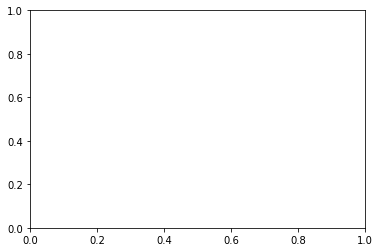

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(actual_list)